# **Part A**

## Step 0 : Loading essential libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
import re
### Importing nltk library for stopwords and punctuations
import nltk 
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

### importing sklearn libraries for LogisticRegression and confusion matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


at this step we import the dataset:
this data set has 4846 rows and the first column is sentiment of the text and the second column is the text itself.

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/NLP/HW2/FinancialPhraseBank-v1.0/all-data.csv',encoding = "ISO-8859-1", names=['sentiment','text'], delimiter= ',')
df


,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


## Step 1 : preprocessings

In [ ]:
def clean_text(text):
    # Remove URLs, mentions, and hashtags using regular expressions
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#([^\s]+)', '', text)
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub('[^a-zA-Z]', ' ', text.lower())
    # Tokenize the text into words
    words = word_tokenize(text)
    # Remove stop words
    words = [w for w in words if not w in set(stopwords.words('english'))]
    # Join the remaining words back into a string
    text = ' '.join(words)
    return text


In [ ]:
df['text'] = df['text'].apply(lambda x : clean_text(x))
df.head()

,sentiment,text
0,neutral,according gran company plans move production r...
1,neutral,technopolis plans develop stages area less squ...
2,negative,international electronic industry company elco...
3,positive,new production plant company would increase ca...
4,positive,according company updated strategy years baswa...


**first we ran without dropping index 2983 and when we saw embeddings of df, we saw the embedding of 2983th item is zero. so we dropped it**

In [ ]:
df = df.drop(df.index[2983])

## Part2 : create embeddings using GloVe

First we get the glove pretrained word vectors: (we use 6B as said in HW)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-04-29 11:19:39--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-29 11:19:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-29 11:19:40--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

then we unzip the downloaded files

In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


create an array of all 100d embeddings of each word

In [ ]:
# Initialize an empty dictionary to store the word embeddings
glv_embedding = {}

# Open the file and read line by line
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as file:
    for line in file:
        # Split each line by space
        values = line.split()
        # The first value is the word itself
        word = values[0]
        # The remaining values are the coefficients for the word embedding
        coefficients = np.asarray(values[1:], dtype='float32')
        # Add the word and its coefficients to the dictionary
        glv_embedding[word] = coefficients


  

In [ ]:
def get_sentence_embedding(sentence, embeddings):
    # Initialize an empty list to store the embeddings for each word
    word_embeddings = []
    
    # Iterate over each word in the sentence
    for word in sentence:
        # Check if the word is in the embedding dictionary
        if word in embeddings:
            # Get the embedding vector for the word and append it to the list
            embedding_vector = embeddings[word]
            word_embeddings.append(embedding_vector)
    
    # If there are no embeddings for any of the words in the sentence, return None
    if not word_embeddings:
        return None
    
    # Compute the mean of the embeddings for all the words in the sentence
    sentence_embedding = np.mean(word_embeddings, axis=0)
    
    return sentence_embedding

In [ ]:
# Initialize an empty list to store the preprocessed sentences
preprocessed_sentences = []
vectors = []

# Iterate over the rows of the DataFrame
for _, row in df.iterrows():
    # Convert the text to lowercase and tokenize it into words
    words = [word.lower() for word in word_tokenize(row['text']) if word.isalpha()]
    # Append the list of words to the preprocessed_sentences list
    preprocessed_sentences.append(words)

    vec = get_sentence_embedding(words,glv_embedding)
    vectors.append(vec)

Implement a function to turn column of negative and possitive to -1,1 and 0

In [ ]:
def oneHot(row):
  if row=='negative': return -1
  if row=='neutral' : return  0
  if row=='positive' : return +1

In [ ]:
df['sentiment'] = df['sentiment'].apply(oneHot)

## Step 3 :Splitting train and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(vectors), df['sentiment'],  test_size= 0.1, random_state= 45,shuffle=True)

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_pred, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Accuracy on test set: 0.715

Confusion matrix:
[[ 25   6   6]
 [ 20 255  66]
 [ 10  26  71]]


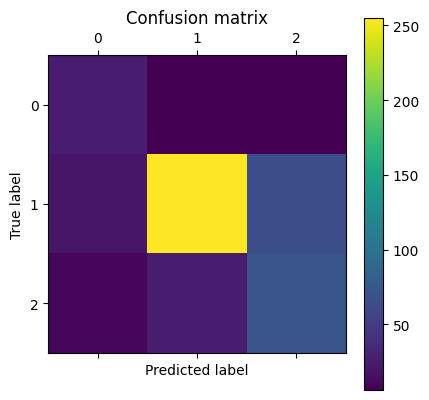


               precision    recall  f1-score   support

          -1       0.68      0.45      0.54        55
           0       0.75      0.89      0.81       287
           1       0.66      0.50      0.57       143

    accuracy                           0.72       485
   macro avg       0.70      0.61      0.64       485
weighted avg       0.71      0.72      0.71       485



In [ ]:
print("\nAccuracy on test set: {:.3f}\n".format(lr.score(X_train,y_train )) )
print("Confusion matrix:\n{}".format(cm))


#Show confusion matrix in a separate window
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print("\n",classification_report(y_test,y_pred))

# **Part B**

In this part we want to know what is the impact of imbalanced dat, so first we plot the data distribution:

<Axes: xlabel='sentiment', ylabel='count'>

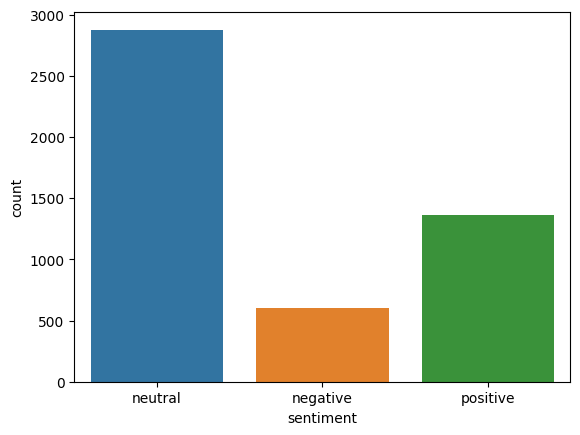

In [ ]:
sns.countplot(x = 'sentiment', data = df)


# **Part C**

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = lr.predict(X_test)
cm_nb = confusion_matrix(y_pred_nb, y_test)


Accuracy on test set: 0.597

Confusion matrix:
[[ 25   6   6]
 [ 20 255  66]
 [ 10  26  71]]


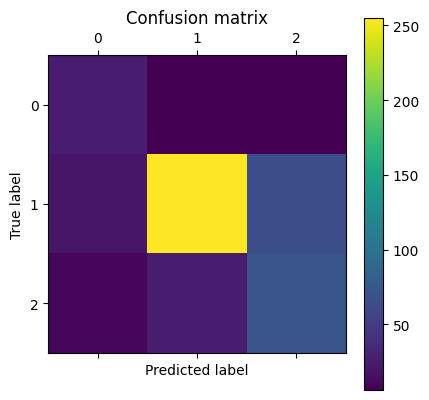


               precision    recall  f1-score   support

          -1       0.68      0.45      0.54        55
           0       0.75      0.89      0.81       287
           1       0.66      0.50      0.57       143

    accuracy                           0.72       485
   macro avg       0.70      0.61      0.64       485
weighted avg       0.71      0.72      0.71       485



In [ ]:
print("\nAccuracy on test set: {:.3f}\n".format(nb.score(X_train,y_train )) )
print("Confusion matrix:\n{}".format(cm_nb))


#Show confusion matrix in a separate window
plt.matshow(cm_nb)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print("\n",classification_report(y_test,y_pred_nb))